# 6.6.1. LeNet

data Flow

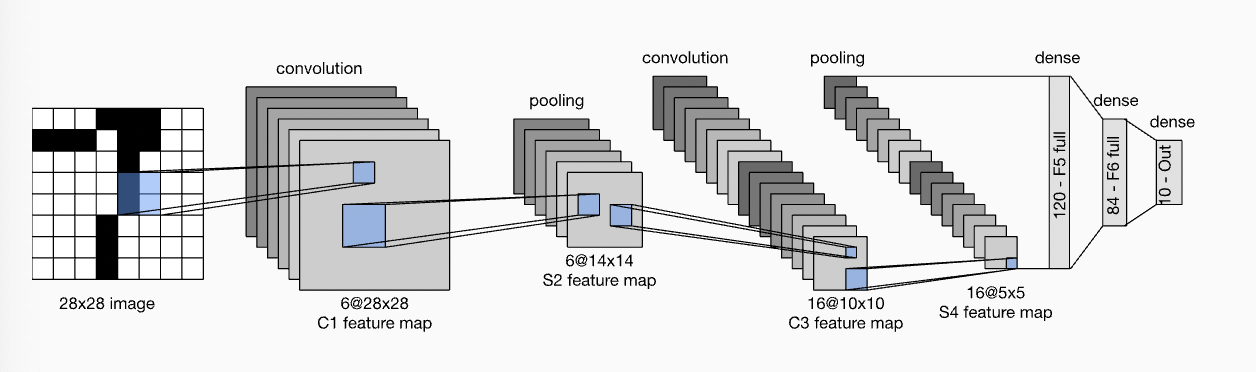


각 conv layer는 5x5 kernel과 sigmoid activation function 사용. 
relu와 maxPooling이 개발 안된 시점이라서)

flatten 하는 과정에서는, minibatch를 유지한 상태에서, 4차원의 입력을 2차원으로 flatten하여 계산해 준 다음 reshape해줘서 결과를 뽑아내면 된다.
120 -> 84 -> 10 outputs으로 진행됨

In [3]:
import torch
import torch.nn as nn
from d2l import torch as d2l

'''
conv output = 1 + {(H+2P-F)/S}
pooling output = input size/output size
'''

# input size eg.(28,28)
net = nn.Sequential(
    # output (28,28)
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    # output (14,14)
    nn.AvgPool2d(kernel_size=2, stride=2),
    # output (10,10)
    nn.Conv2d(6,16,kernel_size=5), nn.Sigmoid(),
    # output (5,5)
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84,10))

X = torch.rand(size=(1,1,28,28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


입력으로 single-channel의 흑백 이미지를 받고, conv layer -> fc 순으로 진행된다

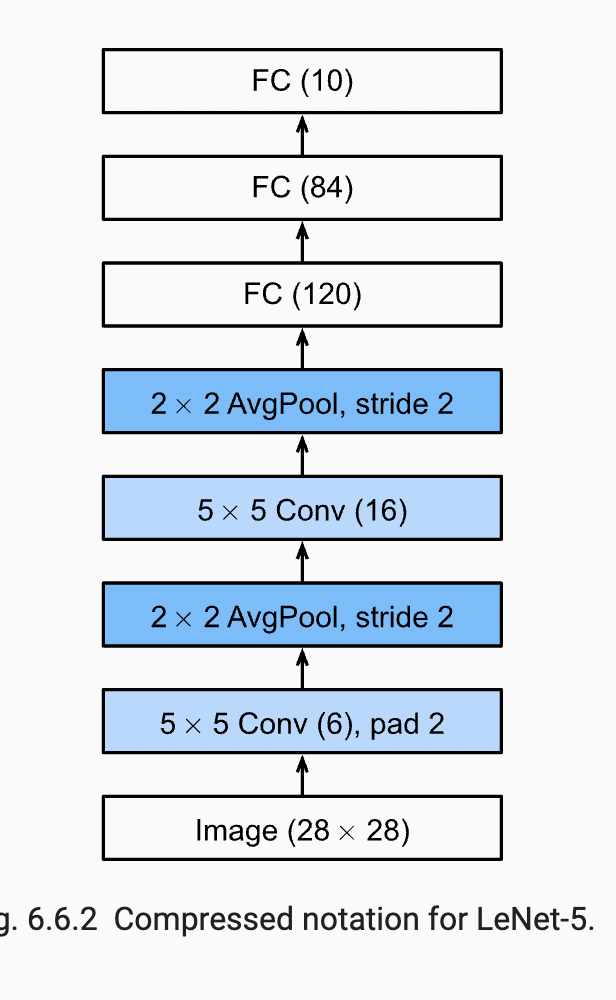

# 6.6.2. Training

In [21]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

/Users/seyeon/Desktop/d2i_pytorch/d2i_env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [22]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    
    with torch.no_grad():
        for X,y in data_iter:
                if isinstance(X, list):
                    X = [x.to(device) for x in X]
                else:
                    X = X.to(device)
                y = y.to(device)
                metric.add(d2l.accuracy(net(X),y), y.numel())
    return metric[0]/metric[1]

In [25]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
            
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1,num_epochs],
                           legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        
        net.train()
        
        for i, (X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat,y), X.shape[0])
            timer.stop()
            train_l = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            
            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches,
                            (train_l, train_acc, None))
                
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None,None,test_acc))
        
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
            
    

loss 0.474, train acc 0.821, test acc 0.774
5598.5 examples/sec on cpu


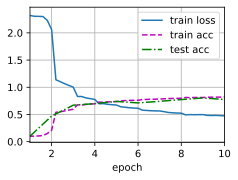

In [26]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())